# Feature Engineering with Weather Data

This notebook extends our feature engineering pipeline by incorporating weather data from NOAA alongside the PJM energy consumption data. The goal is to create a rich feature set that captures both temporal patterns and weather effects on energy consumption.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import holidays
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
def load_and_preprocess_data(pjm_path='../../public/data/pjm_dataset/pjm_hourly_est.csv',
                           weather_path='../../public/data/weather/noaa_data.csv'):
    """
    Load and perform initial preprocessing of PJM and weather data
    """
    # Read PJM data
    df_pjm = pd.read_csv(pjm_path, parse_dates=['Datetime'])
    
    # Read weather data
    df_weather = pd.read_csv(weather_path, parse_dates=['timestamp'])
    
    # Filter PJM date range to where we have most complete data
    df_pjm = df_pjm[(df_pjm['Datetime'] >= '2002-04-01') & 
                    (df_pjm['Datetime'] <= '2018-08-03')]
    
    # Focus on PJME and PJMW
    df_pjm = df_pjm[['Datetime', 'PJME', 'PJMW']]
    
    # Handle missing values in PJMW
    df_pjm['PJMW'] = df_pjm['PJMW'].fillna(method='ffill')
    
    # Merge weather data
    df_weather = df_weather.rename(columns={'timestamp': 'Datetime'})
    df = pd.merge(df_pjm, df_weather, on='Datetime', how='left')
    
    return df

# Load the data
df = load_and_preprocess_data()

# Display basic information
print("Dataset Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (143207, 33)

Missing values:
Datetime                      0
PJME                          0
PJMW                          0
avg_wind_speed                0
precipitation                 0
avg_temperature               0
max_temperature               0
min_temperature               0
temperature                   0
avg_wind_speed_chicago        0
precipitation_chicago         0
avg_temperature_chicago       0
max_temperature_chicago       0
min_temperature_chicago       0
temperature_chicago           0
avg_wind_speed_washington     0
precipitation_washington      0
avg_temperature_washington    0
max_temperature_washington    0
min_temperature_washington    0
temperature_washington        0
avg_wind_speed_pittsburgh     0
precipitation_pittsburgh      0
avg_temperature_pittsburgh    0
max_temperature_pittsburgh    0
min_temperature_pittsburgh    0
temperature_pittsburgh        0
avg_wind_speed_columbus       0
precipitation_columbus        0
avg_temperature_columbus   

In [3]:
def create_weather_features(df):
    """
    Create weather-based features
    """
    df = df.copy()
    
    # Calculate regional average temperatures
    temp_cols = [col for col in df.columns if 'temperature' in col and 
                 not any(x in col for x in ['max_', 'min_', 'avg_'])]
    df['regional_temp_mean'] = df[temp_cols].mean(axis=1)
    df['regional_temp_std'] = df[temp_cols].std(axis=1)
    
    # Calculate regional average wind speeds
    wind_cols = [col for col in df.columns if 'wind_speed' in col]
    df['regional_wind_mean'] = df[wind_cols].mean(axis=1)
    df['regional_wind_std'] = df[wind_cols].std(axis=1)
    
    # Calculate regional average precipitation
    precip_cols = [col for col in df.columns if 'precipitation' in col]
    df['regional_precip_mean'] = df[precip_cols].mean(axis=1)
    df['regional_precip_std'] = df[precip_cols].std(axis=1)
    
    # Create temperature difference features
    df['temp_change_24h'] = df['regional_temp_mean'].diff(24)
    df['temp_change_48h'] = df['regional_temp_mean'].diff(48)
    
    # Create extreme weather indicators
    df['is_extreme_temp'] = ((df['regional_temp_mean'] > df['regional_temp_mean'].quantile(0.95)) | 
                            (df['regional_temp_mean'] < df['regional_temp_mean'].quantile(0.05))).astype(int)
    df['is_high_wind'] = (df['regional_wind_mean'] > df['regional_wind_mean'].quantile(0.95)).astype(int)
    df['is_heavy_precip'] = (df['regional_precip_mean'] > df['regional_precip_mean'].quantile(0.95)).astype(int)
    
    return df

# Create weather features
df_weather = create_weather_features(df)

# Display new features
weather_features = [col for col in df_weather.columns if col not in df.columns]
print("New weather features created:", weather_features)

New weather features created: ['regional_temp_mean', 'regional_temp_std', 'regional_wind_mean', 'regional_wind_std', 'regional_precip_mean', 'regional_precip_std', 'temp_change_24h', 'temp_change_48h', 'is_extreme_temp', 'is_high_wind', 'is_heavy_precip']


In [4]:
def create_temporal_features(df):
    """
    Create time-based features
    """
    df = df.copy()
    
    # Basic time features
    df['hour'] = df['Datetime'].dt.hour
    df['day'] = df['Datetime'].dt.day
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['quarter'] = df['Datetime'].dt.quarter
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
    
    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['timeofday'] = pd.cut(df['hour'],
                            bins=[-1, 6, 12, 17, 23],
                            labels=['night', 'morning', 'afternoon', 'evening'])
    
    return df

# Create temporal features
df_temporal = create_temporal_features(df_weather)

In [5]:
def create_holiday_features(df):
    """
    Add holiday-related features
    """
    us_holidays = holidays.US()
    
    df['is_holiday'] = df['Datetime'].dt.date.apply(
        lambda x: 1 if x in us_holidays else 0
    )
    
    df['is_day_before_holiday'] = df['Datetime'].dt.date.apply(
        lambda x: 1 if (x + timedelta(days=1)) in us_holidays else 0
    )
    
    df['is_day_after_holiday'] = df['Datetime'].dt.date.apply(
        lambda x: 1 if (x - timedelta(days=1)) in us_holidays else 0
    )
    
    return df

# Create holiday features
df_holidays = create_holiday_features(df_temporal)

In [6]:
def create_lagged_features(df, target_col='PJME', lags=[1, 24, 48, 168]):
    """
    Create lagged features for both energy and weather
    """
    df = df.copy()
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}h'] = df[target_col].shift(lag)
        df[f'temp_lag_{lag}h'] = df['regional_temp_mean'].shift(lag)
        df[f'wind_lag_{lag}h'] = df['regional_wind_mean'].shift(lag)
        
    return df

def create_rolling_features(df, target_col='PJME',
                          windows=[24, 168], stats=['mean', 'std']):
    """
    Create rolling window features
    """
    df = df.copy()
    
    for window in windows:
        for stat in stats:
            df[f'{target_col}_roll_{window}h_{stat}'] = getattr(
                df[target_col].rolling(window, min_periods=1), stat
            )()
            df[f'temp_roll_{window}h_{stat}'] = getattr(
                df['regional_temp_mean'].rolling(window, min_periods=1), stat
            )()
            df[f'wind_roll_{window}h_{stat}'] = getattr(
                df['regional_wind_mean'].rolling(window, min_periods=1), stat
            )()
    
    return df

# Create lagged and rolling features
df_lagged = create_lagged_features(df_holidays)
df_rolling = create_rolling_features(df_lagged)

In [7]:
def handle_missing_values(df):
    """
    Handle missing values
    """
    df = df.copy()
    
    # Handle different types of features
    holiday_cols = ['is_holiday', 'is_day_before_holiday', 'is_day_after_holiday']
    df[holiday_cols] = df[holiday_cols].fillna(0)
    
    # Handle lagged and rolling features
    lag_roll_cols = [col for col in df.columns if 'lag' in col or 'roll' in col]
    df[lag_roll_cols] = df[lag_roll_cols].fillna(method='ffill').fillna(method='bfill')
    
    # Handle weather features
    weather_cols = [col for col in df.columns if any(x in col.lower() for x in 
                   ['temp', 'wind', 'precip'])]
    for col in weather_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
    
    # Handle remaining numerical features
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())
    
    return df

def scale_features(df, exclude_cols=['Datetime', 'PJME', 'timeofday']):
    """
    Scale numerical features
    """
    cols_to_scale = [col for col in df.columns 
                     if col not in exclude_cols and 
                     df[col].dtype in ['int64', 'float64']]
    
    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    
    return df, scaler

# Process features
df_processed = handle_missing_values(df_rolling)
df_scaled, scaler = scale_features(df_processed)

In [8]:
def split_data(df, test_size=0.2):
    """
    Split data into training and testing sets
    """
    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test

def validate_features(df_featured):
    """
    Validate the engineered features
    """
    # Check correlations with target
    numeric_df = df_featured.select_dtypes(include=['float64', 'int64'])
    correlations = numeric_df.corr()['PJME'].sort_values(ascending=False)
    
    print("Top 10 feature correlations with PJME:")
    print(correlations[:10])
    
    return correlations

# Split and validate data
train_data, test_data = split_data(df_scaled)
correlations = validate_features(df_scaled)

# Save processed data
train_data.to_csv('../../data/processed/train_data_weather.csv', index=False)
test_data.to_csv('../../data/processed/test_data_weather.csv', index=False)
print("\nProcessed data saved to CSV files")

Top 10 feature correlations with PJME:
PJME                   1.000000
PJME_lag_1h            0.970414
PJME_lag_24h           0.891092
PJMW                   0.875717
PJME_lag_168h          0.778177
PJME_lag_48h           0.772462
PJME_roll_24h_mean     0.675638
PJME_roll_168h_mean    0.567307
PJME_roll_24h_std      0.387452
PJME_roll_168h_std     0.362182
Name: PJME, dtype: float64

Processed data saved to CSV files


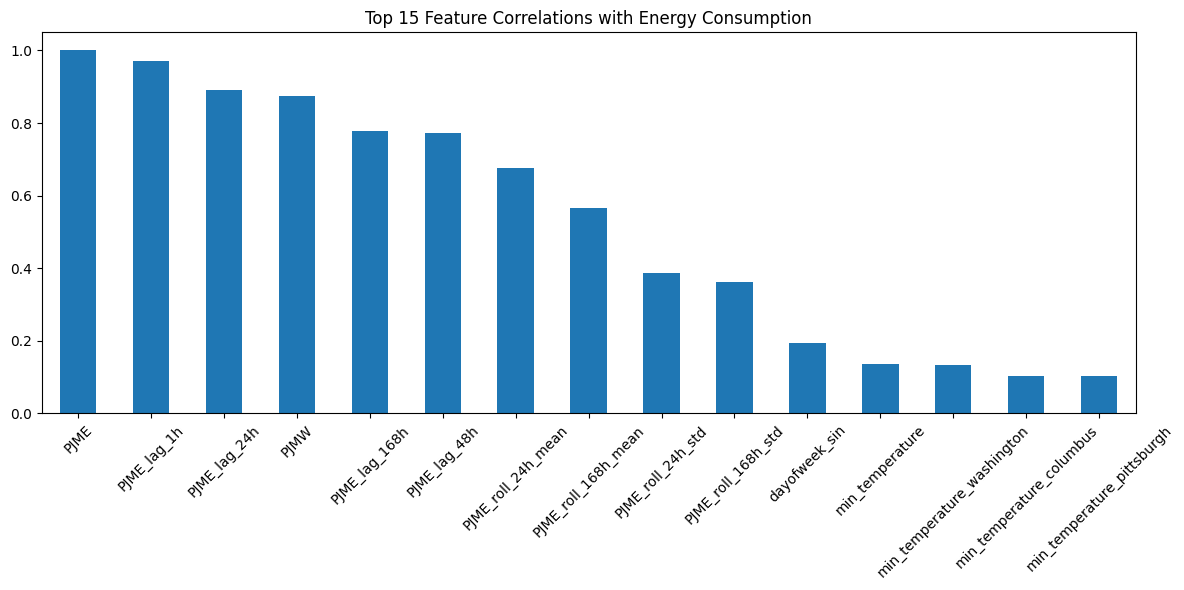

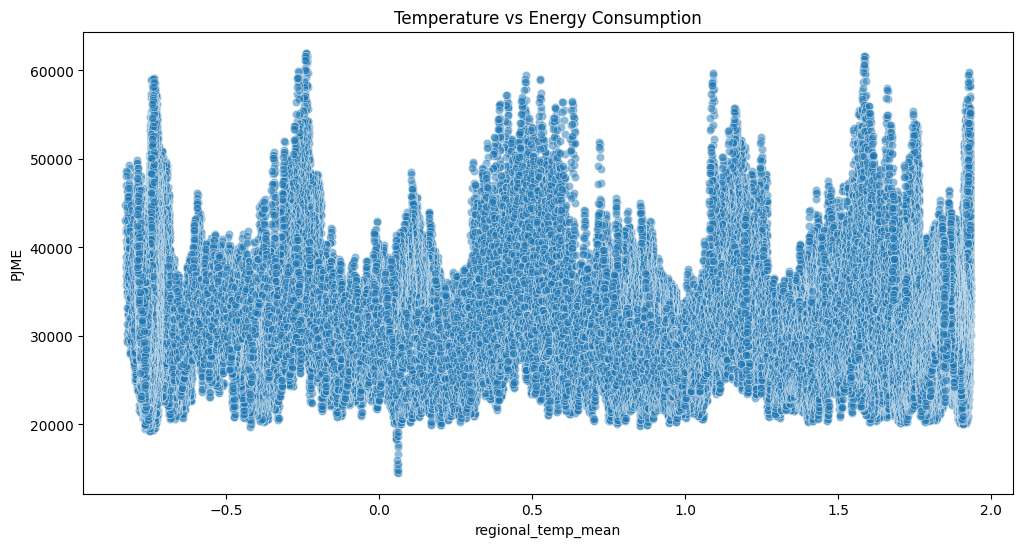

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot top feature correlations
plt.figure(figsize=(12, 6))
correlations[:15].plot(kind='bar')
plt.title('Top 15 Feature Correlations with Energy Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze weather impact
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_scaled, x='regional_temp_mean', y='PJME', alpha=0.5)
plt.title('Temperature vs Energy Consumption')
plt.show()